### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sys
import numpy as np
import joblib

sys.path.append('../src')

from NestedCrossValidation import NestedCrossValidation

### Configuration

#### Constants

In [2]:
SEED=42
DESCRIBE_DATASET=False
GENERATE_HEATMAPS=False
CHECK_DUPLICATE_ROWS=False
RUN_ONE_CASE=True
SOURCE_FILE = "../data_preprocessed/everything40_cleaned_normalized_reduced.csv"
REPETITIONS = 10
K = 5 # External fold iteration
L = 3 # Internal fold iterations
VERBOSE = True

APPLY_SAMPLE_CUT_OFF = False
LIMIT_SAMPLES = 2000 # sample cells
LIMIT_FEATURES = 500 # sample genes

np.random.seed(42) 

#### Algorithms and hyperparameter space

In [3]:
classifiers = {
    'Logistic Regression': {
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30, 40]
    },
    'k-Nearest Neighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance', None]
    },
    'Linear Discriminant Analysis': {
        'tol': [1e-10, 1e-9, 1e-8],
        'solver': ['svd', 'lsqr', 'eigen']
    },
    'Support Vector Machines': {
        'kernel': ['poly', 'linear', 'rbf'],
        'C': [0.5, 1, 1.5, 2]
    }
}

metrics = [
    'Balanced Accuracy',
    'F1 Score',
    'Sensitivity (Recall)',
    'Precision'
]

### Helper functions

In [4]:
def trainOneAlgorithm(nCV, algorithm):
    nCV.initializeMetricStatistics()

    nCV.trainSpecificAlgorithmCV(algorithm, REPETITIONS)

    nCV.printMetricStatistics(algorithm)

    best_algorithm, median_scores = nCV.findBestModelForAlgorithm(algorithm)

    best, report = nCV.trainBestModel(best_algorithm)

    return best, report

### Load dataset

In [5]:
%%time
dataset = pd.read_csv(SOURCE_FILE,index_col = 0)

if APPLY_SAMPLE_CUT_OFF:
    print("Applying cut off: ", LIMIT_SAMPLES, LIMIT_FEATURES)
    print("Before cut off: ", dataset.shape)
    dataset = dataset.iloc[0:LIMIT_SAMPLES, dataset.shape[1]-LIMIT_FEATURES:]
    print("After cut off: ", dataset.shape)

CPU times: total: 93.8 ms
Wall time: 182 ms


In [6]:
print("Total samples: ", dataset.shape[0])
print("Total genes  : ", dataset.shape[1])

Total samples:  4679
Total genes  :  139


### Assess the algorithms

#### initialize NestedCross validator

In [7]:
nCV = NestedCrossValidation(dataset, classifiers, K, L, metrics, VERBOSE)

nCV.printInfo()

NestedCrossValidation initialized:
  - Dataset shape    : (4679, 139)
  - Total classifiers: 5
  - Classifiers      :  {'Logistic Regression': {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.1, 1, 10]}, 'Random Forest': {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20, 30, 40]}, 'k-Nearest Neighbors': {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance', None]}, 'Linear Discriminant Analysis': {'tol': [1e-10, 1e-09, 1e-08], 'solver': ['svd', 'lsqr', 'eigen']}, 'Support Vector Machines': {'kernel': ['poly', 'linear', 'rbf'], 'C': [0.5, 1, 1.5, 2]}}
  - Outer loops      :  5
  - Inner loops      :  3
  - Metrics          :  ['Balanced Accuracy', 'F1 Score', 'Sensitivity (Recall)', 'Precision']


##### Logistic Regression

In [8]:
%%time

best, report = trainOneAlgorithm(nCV, 'Logistic Regression')

joblib.dump(best,  '../models/logistic_regression_model.pkl')

(4679, 138)
(4679,)
Logistic Regression  - Repetition:  1  Fold:  1
Logistic Regression  - Repetition:  1  Fold:  2
Logistic Regression  - Repetition:  1  Fold:  3
Logistic Regression  - Repetition:  1  Fold:  4
Logistic Regression  - Repetition:  1  Fold:  5
Logistic Regression  - Repetition:  2  Fold:  1
Logistic Regression  - Repetition:  2  Fold:  2
Logistic Regression  - Repetition:  2  Fold:  3
Logistic Regression  - Repetition:  2  Fold:  4
Logistic Regression  - Repetition:  2  Fold:  5
Logistic Regression  - Repetition:  3  Fold:  1
Logistic Regression  - Repetition:  3  Fold:  2
Logistic Regression  - Repetition:  3  Fold:  3
Logistic Regression  - Repetition:  3  Fold:  4
Logistic Regression  - Repetition:  3  Fold:  5
Logistic Regression  - Repetition:  4  Fold:  1
Logistic Regression  - Repetition:  4  Fold:  2
Logistic Regression  - Repetition:  4  Fold:  3
Logistic Regression  - Repetition:  4  Fold:  4
Logistic Regression  - Repetition:  4  Fold:  5
Logistic Regression 

['../models/logistic_regression_model.pkl']

In [9]:
print(best)

print(report)

LogisticRegression(C=0.1)
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       0.00      0.00      0.00         2
Astro L1-6 FGFR3 SLC14A1       0.83      1.00      0.91        15
        Exc L2 LAMP5 LTK       0.36      0.38      0.37        64
Exc L2-3 LINC00507 FREM3       0.58      0.76      0.66       155
Exc L2-4 LINC00507 GLP2R       0.71      0.38      0.50        13
   Exc L3-4 RORB CARM1P1       0.30      0.25      0.27        28
   Exc L3-5 RORB COL22A1       0.12      0.11      0.12         9
      Exc L3-5 RORB ESR1       0.64      0.82      0.72       111
   Exc L3-5 RORB FILIP1L       0.25      0.06      0.10        16
    Exc L3-5 RORB TWIST2       0.00      0.00      0.00         8
    Exc L4-5 FEZF2 SCN4B       1.00      0.50      0.67         2
     Exc L4-5 RORB DAPK2       0.25      0.17      0.20        12
    Exc L4-5 RORB FOLH1B       0.64      0.64      0.64        72
     Exc L4-6 FEZF2 IL26       0.79      0.67    

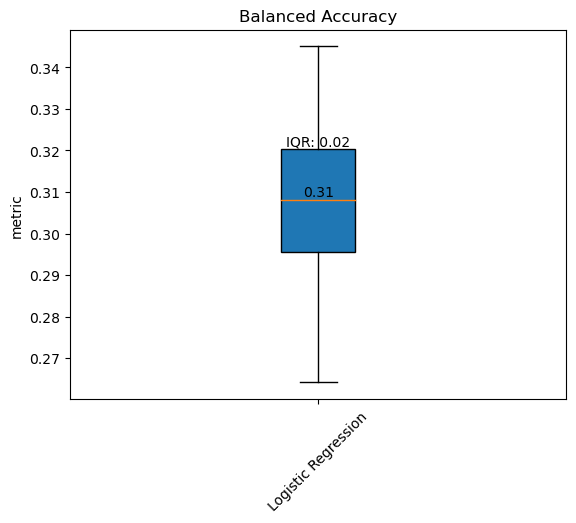

In [10]:
metric = 'Balanced Accuracy'
nCV.plotMetric(metric, 'Logistic Regression')

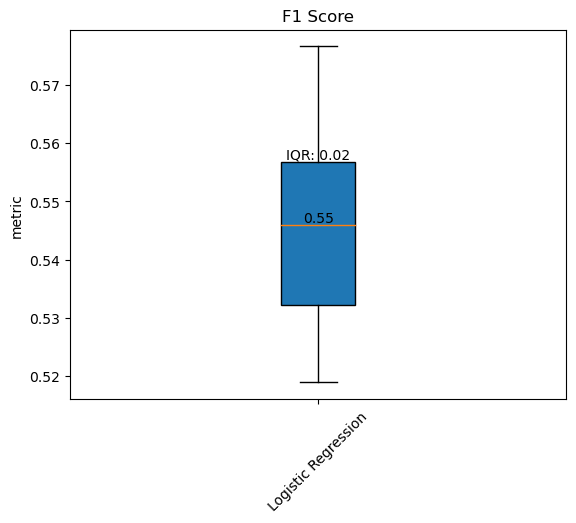

In [11]:
metric = 'F1 Score'
nCV.plotMetric(metric, 'Logistic Regression')

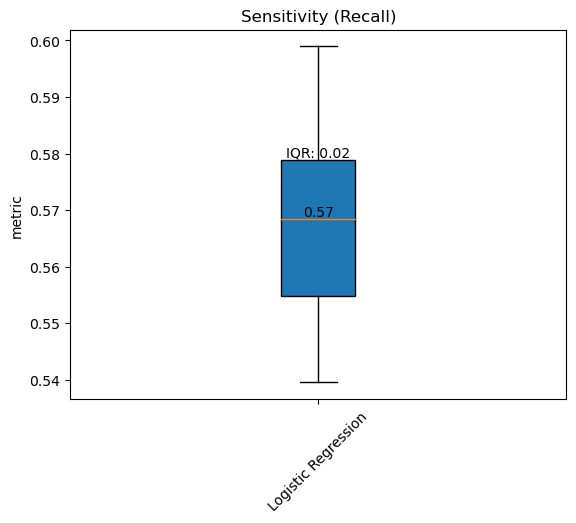

In [12]:
metric = 'Sensitivity (Recall)'
nCV.plotMetric(metric, 'Logistic Regression')

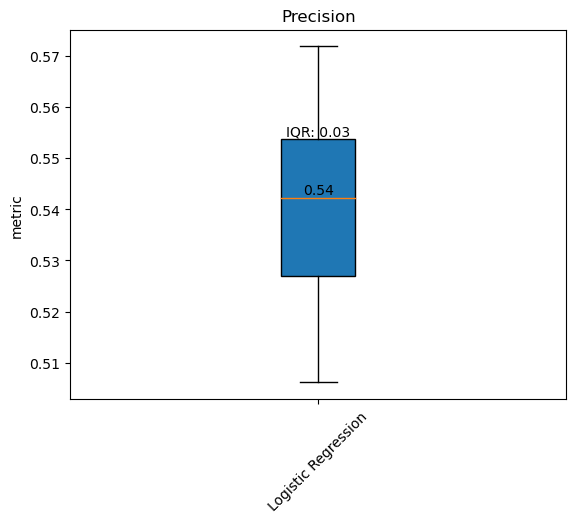

In [13]:
metric = 'Precision'
nCV.plotMetric(metric, 'Logistic Regression')

##### Random Forest

In [14]:
%%time

best, report = trainOneAlgorithm(nCV, 'Random Forest')

joblib.dump(best,  '../models/random_forest_model.pkl')

(4679, 138)
(4679,)
Random Forest  - Repetition:  1  Fold:  1
Random Forest  - Repetition:  1  Fold:  2
Random Forest  - Repetition:  1  Fold:  3
Random Forest  - Repetition:  1  Fold:  4
Random Forest  - Repetition:  1  Fold:  5
Random Forest  - Repetition:  2  Fold:  1
Random Forest  - Repetition:  2  Fold:  2
Random Forest  - Repetition:  2  Fold:  3
Random Forest  - Repetition:  2  Fold:  4
Random Forest  - Repetition:  2  Fold:  5
Random Forest  - Repetition:  3  Fold:  1
Random Forest  - Repetition:  3  Fold:  2
Random Forest  - Repetition:  3  Fold:  3
Random Forest  - Repetition:  3  Fold:  4
Random Forest  - Repetition:  3  Fold:  5
Random Forest  - Repetition:  4  Fold:  1
Random Forest  - Repetition:  4  Fold:  2
Random Forest  - Repetition:  4  Fold:  3
Random Forest  - Repetition:  4  Fold:  4
Random Forest  - Repetition:  4  Fold:  5
Random Forest  - Repetition:  5  Fold:  1
Random Forest  - Repetition:  5  Fold:  2
Random Forest  - Repetition:  5  Fold:  3
Random Forest 

['../models/random_forest_model.pkl']

In [15]:
print(best)

print(report)

RandomForestClassifier(max_depth=30, n_estimators=500)
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       0.00      0.00      0.00         3
Astro L1-6 FGFR3 SLC14A1       0.82      1.00      0.90        14
        Exc L2 LAMP5 LTK       0.41      0.35      0.38        54
Exc L2-3 LINC00507 FREM3       0.51      0.90      0.65       184
Exc L2-4 LINC00507 GLP2R       0.20      0.09      0.13        11
   Exc L3-4 RORB CARM1P1       0.00      0.00      0.00        21
   Exc L3-5 RORB COL22A1       0.00      0.00      0.00        18
      Exc L3-5 RORB ESR1       0.42      0.89      0.57       108
   Exc L3-5 RORB FILIP1L       0.00      0.00      0.00        10
    Exc L3-5 RORB TWIST2       0.00      0.00      0.00         9
    Exc L4-5 FEZF2 SCN4B       0.00      0.00      0.00         1
     Exc L4-5 RORB DAPK2       0.00      0.00      0.00        11
    Exc L4-5 RORB FOLH1B       0.65      0.53      0.58        76
     Exc L4-6 FEZF2 

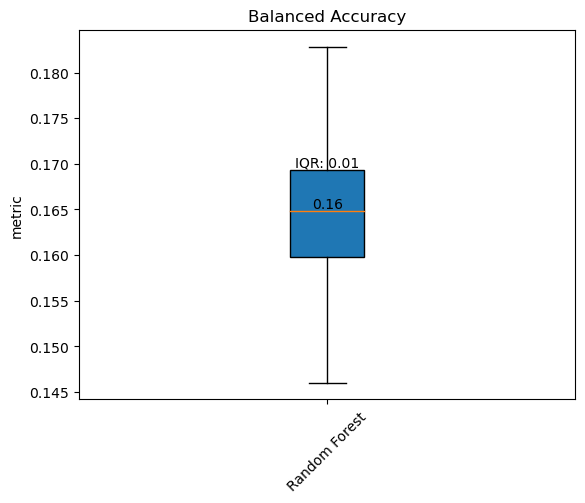

In [16]:
metric = 'Balanced Accuracy'
nCV.plotMetric(metric, 'Random Forest')

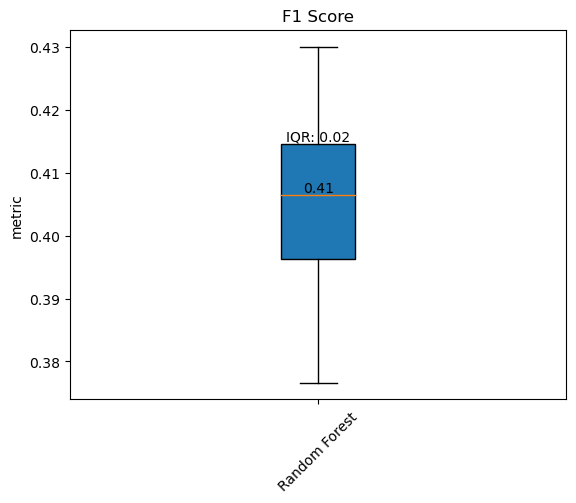

In [17]:
metric = 'F1 Score'
nCV.plotMetric(metric, 'Random Forest')

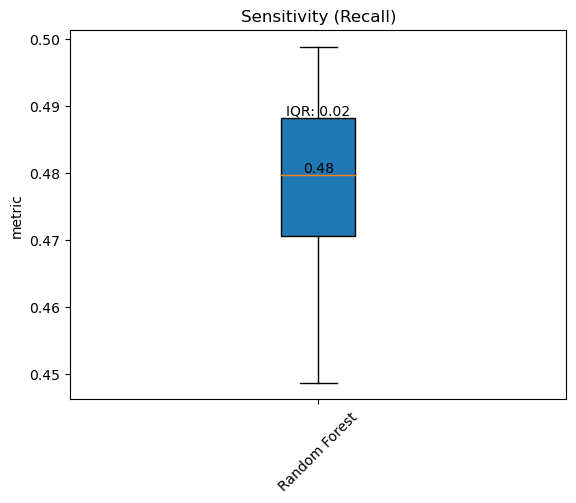

In [18]:
metric = 'Sensitivity (Recall)'
nCV.plotMetric(metric, 'Random Forest')

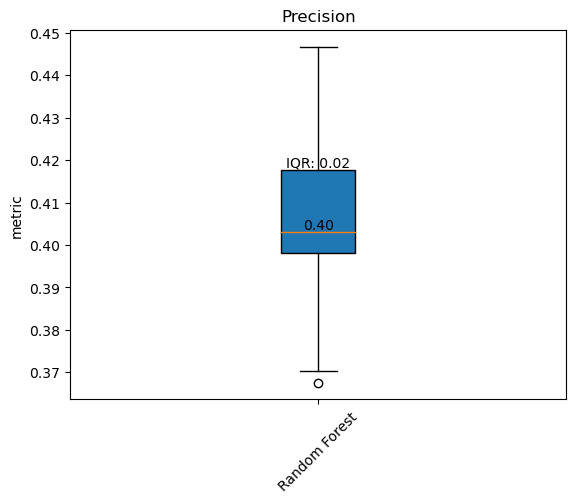

In [19]:
metric = 'Precision'
nCV.plotMetric(metric, 'Random Forest')

##### k-Nearest Neighbors

In [20]:
%%time

best, report = trainOneAlgorithm(nCV, 'k-Nearest Neighbors')

joblib.dump(best,  '../models/k_nearest_neighbors.pkl')

(4679, 138)
(4679,)
k-Nearest Neighbors  - Repetition:  1  Fold:  1
k-Nearest Neighbors  - Repetition:  1  Fold:  2
k-Nearest Neighbors  - Repetition:  1  Fold:  3
k-Nearest Neighbors  - Repetition:  1  Fold:  4
k-Nearest Neighbors  - Repetition:  1  Fold:  5
k-Nearest Neighbors  - Repetition:  2  Fold:  1
k-Nearest Neighbors  - Repetition:  2  Fold:  2
k-Nearest Neighbors  - Repetition:  2  Fold:  3
k-Nearest Neighbors  - Repetition:  2  Fold:  4
k-Nearest Neighbors  - Repetition:  2  Fold:  5
k-Nearest Neighbors  - Repetition:  3  Fold:  1
k-Nearest Neighbors  - Repetition:  3  Fold:  2
k-Nearest Neighbors  - Repetition:  3  Fold:  3
k-Nearest Neighbors  - Repetition:  3  Fold:  4
k-Nearest Neighbors  - Repetition:  3  Fold:  5
k-Nearest Neighbors  - Repetition:  4  Fold:  1
k-Nearest Neighbors  - Repetition:  4  Fold:  2
k-Nearest Neighbors  - Repetition:  4  Fold:  3
k-Nearest Neighbors  - Repetition:  4  Fold:  4
k-Nearest Neighbors  - Repetition:  4  Fold:  5
k-Nearest Neighbors 

['../models/k_nearest_neighbors.pkl']

In [21]:
print(best)

print(report)

KNeighborsClassifier(n_neighbors=10, weights='distance')
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       0.00      0.00      0.00         3
Astro L1-6 FGFR3 SLC14A1       0.80      0.73      0.76        11
        Exc L2 LAMP5 LTK       0.26      0.40      0.32        70
Exc L2-3 LINC00507 FREM3       0.45      0.64      0.53       159
Exc L2-4 LINC00507 GLP2R       0.57      0.29      0.38        14
   Exc L3-4 RORB CARM1P1       0.29      0.07      0.12        27
   Exc L3-5 RORB COL22A1       0.00      0.00      0.00        10
      Exc L3-5 RORB ESR1       0.26      0.89      0.40       117
   Exc L3-5 RORB FILIP1L       0.00      0.00      0.00        15
    Exc L3-5 RORB TWIST2       0.00      0.00      0.00        10
    Exc L4-5 FEZF2 SCN4B       0.00      0.00      0.00         2
     Exc L4-5 RORB DAPK2       0.43      0.18      0.25        17
    Exc L4-5 RORB FOLH1B       0.70      0.36      0.47        59
     Exc L4-6 FEZF

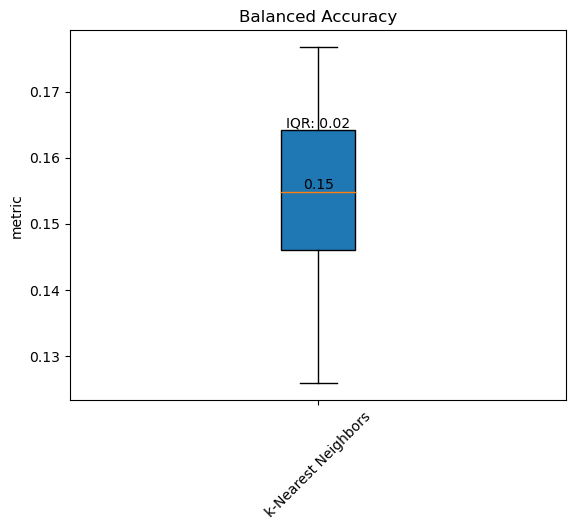

In [22]:
metric = 'Balanced Accuracy'
nCV.plotMetric(metric, 'k-Nearest Neighbors')

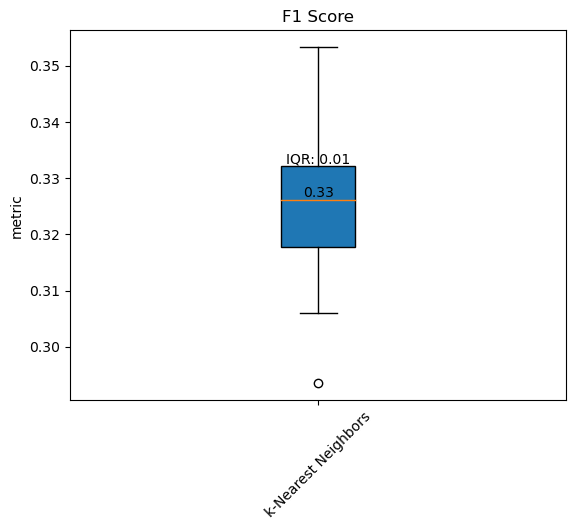

In [23]:
metric = 'F1 Score'
nCV.plotMetric(metric, 'k-Nearest Neighbors')

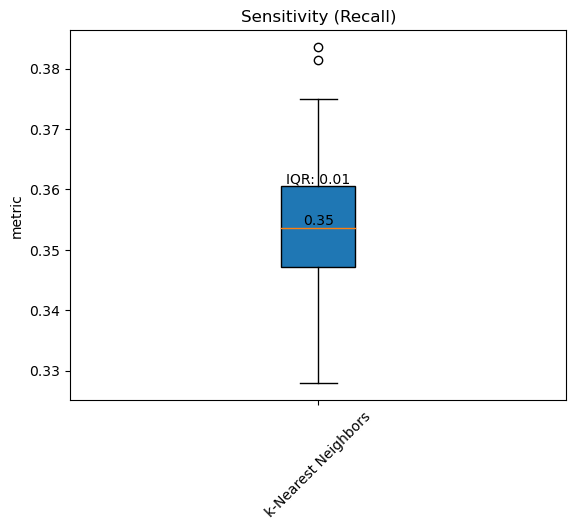

In [24]:
metric = 'Sensitivity (Recall)'
nCV.plotMetric(metric, 'k-Nearest Neighbors')

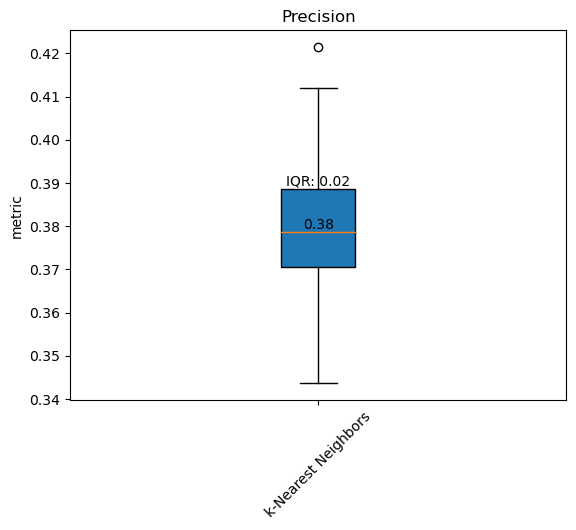

In [25]:
metric = 'Precision'
nCV.plotMetric(metric, 'k-Nearest Neighbors')

##### Linear Discriminant Analysis

In [26]:
%%time

best, report = trainOneAlgorithm(nCV, 'Linear Discriminant Analysis')

joblib.dump(best,  '../models/linear_discriminant_analysis.pkl')

(4679, 138)
(4679,)
Linear Discriminant Analysis  - Repetition:  1  Fold:  1
Linear Discriminant Analysis  - Repetition:  1  Fold:  2
Linear Discriminant Analysis  - Repetition:  1  Fold:  3
Linear Discriminant Analysis  - Repetition:  1  Fold:  4
Linear Discriminant Analysis  - Repetition:  1  Fold:  5
Linear Discriminant Analysis  - Repetition:  2  Fold:  1
Linear Discriminant Analysis  - Repetition:  2  Fold:  2
Linear Discriminant Analysis  - Repetition:  2  Fold:  3
Linear Discriminant Analysis  - Repetition:  2  Fold:  4
Linear Discriminant Analysis  - Repetition:  2  Fold:  5
Linear Discriminant Analysis  - Repetition:  3  Fold:  1
Linear Discriminant Analysis  - Repetition:  3  Fold:  2
Linear Discriminant Analysis  - Repetition:  3  Fold:  3
Linear Discriminant Analysis  - Repetition:  3  Fold:  4
Linear Discriminant Analysis  - Repetition:  3  Fold:  5
Linear Discriminant Analysis  - Repetition:  4  Fold:  1
Linear Discriminant Analysis  - Repetition:  4  Fold:  2
Linear Disc

['../models/linear_discriminant_analysis.pkl']

In [27]:
print(best)

print(report)

LinearDiscriminantAnalysis(tol=1e-10)
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       0.33      0.25      0.29         4
Astro L1-6 FGFR3 SLC14A1       0.68      0.81      0.74        16
       Endo L2-6 NOSTRIN       0.00      0.00      0.00         1
        Exc L2 LAMP5 LTK       0.44      0.44      0.44        64
Exc L2-3 LINC00507 FREM3       0.68      0.68      0.68       168
Exc L2-4 LINC00507 GLP2R       0.31      0.42      0.36        12
   Exc L3-4 RORB CARM1P1       0.36      0.47      0.41        19
   Exc L3-5 RORB COL22A1       0.36      0.50      0.42        10
      Exc L3-5 RORB ESR1       0.53      0.80      0.64       108
   Exc L3-5 RORB FILIP1L       0.06      0.07      0.06        14
    Exc L3-5 RORB TWIST2       0.60      0.25      0.35        12
    Exc L4-5 FEZF2 SCN4B       0.33      0.50      0.40         2
     Exc L4-5 RORB DAPK2       0.33      0.29      0.31         7
    Exc L4-5 RORB FOLH1B       0.73  

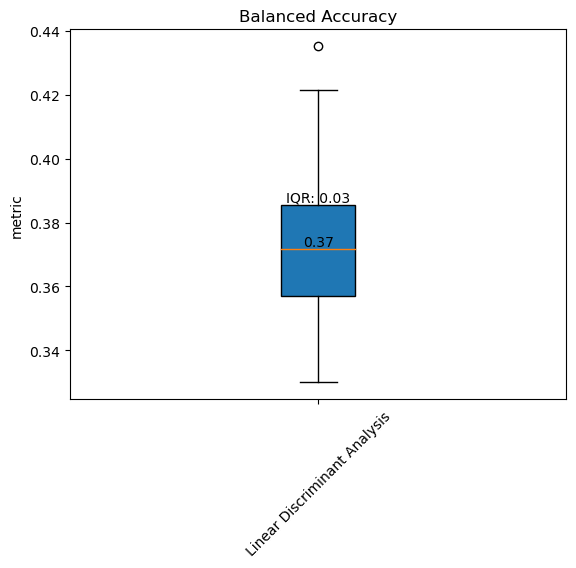

In [28]:
metric = 'Balanced Accuracy'
nCV.plotMetric(metric, 'Linear Discriminant Analysis')

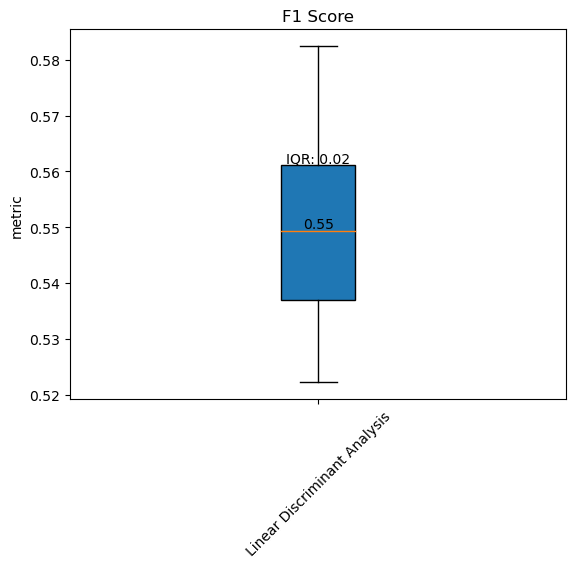

In [29]:
metric = 'F1 Score'
nCV.plotMetric(metric, 'Linear Discriminant Analysis')

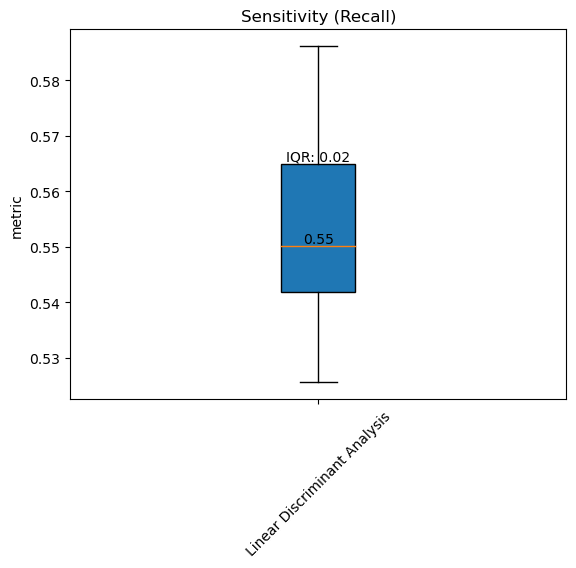

In [30]:
metric = 'Sensitivity (Recall)'
nCV.plotMetric(metric, 'Linear Discriminant Analysis')

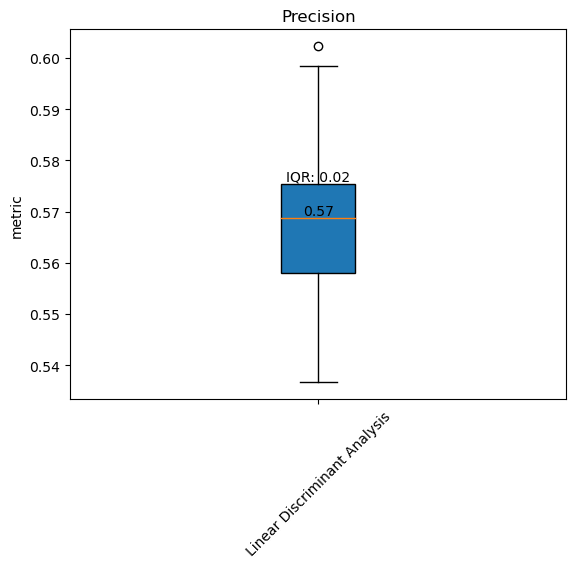

In [31]:
metric = 'Precision'
nCV.plotMetric(metric, 'Linear Discriminant Analysis')

##### Support Vector Machines

In [32]:
%%time

best, report = trainOneAlgorithm(nCV, 'Support Vector Machines')

joblib.dump(best,  '../models/support_vector_machines.pkl')

(4679, 138)
(4679,)
Support Vector Machines  - Repetition:  1  Fold:  1
Support Vector Machines  - Repetition:  1  Fold:  2
Support Vector Machines  - Repetition:  1  Fold:  3
Support Vector Machines  - Repetition:  1  Fold:  4
Support Vector Machines  - Repetition:  1  Fold:  5
Support Vector Machines  - Repetition:  2  Fold:  1
Support Vector Machines  - Repetition:  2  Fold:  2
Support Vector Machines  - Repetition:  2  Fold:  3
Support Vector Machines  - Repetition:  2  Fold:  4
Support Vector Machines  - Repetition:  2  Fold:  5
Support Vector Machines  - Repetition:  3  Fold:  1
Support Vector Machines  - Repetition:  3  Fold:  2
Support Vector Machines  - Repetition:  3  Fold:  3
Support Vector Machines  - Repetition:  3  Fold:  4
Support Vector Machines  - Repetition:  3  Fold:  5
Support Vector Machines  - Repetition:  4  Fold:  1
Support Vector Machines  - Repetition:  4  Fold:  2
Support Vector Machines  - Repetition:  4  Fold:  3
Support Vector Machines  - Repetition:  4  F

['../models/support_vector_machines.pkl']

In [33]:
print(best)

print(report)

SVC(C=2, probability=True)
                          precision    recall  f1-score   support

   Astro L1-2 FGFR3 GFAP       0.00      0.00      0.00         5
Astro L1-6 FGFR3 SLC14A1       0.50      1.00      0.67        10
       Endo L2-6 NOSTRIN       0.00      0.00      0.00         2
        Exc L2 LAMP5 LTK       0.53      0.47      0.50        66
Exc L2-3 LINC00507 FREM3       0.54      0.82      0.65       173
Exc L2-4 LINC00507 GLP2R       0.62      0.36      0.45        14
   Exc L3-4 RORB CARM1P1       0.60      0.33      0.43        18
   Exc L3-5 RORB COL22A1       0.60      0.25      0.35        12
      Exc L3-5 RORB ESR1       0.55      0.85      0.67       117
   Exc L3-5 RORB FILIP1L       0.00      0.00      0.00        19
    Exc L3-5 RORB TWIST2       0.00      0.00      0.00         8
    Exc L4-5 FEZF2 SCN4B       0.00      0.00      0.00         2
     Exc L4-5 RORB DAPK2       0.67      0.14      0.24        14
    Exc L4-5 RORB FOLH1B       0.57      0.76   

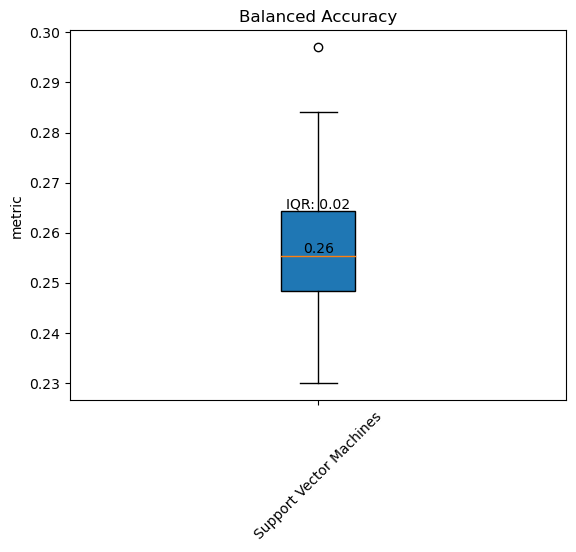

In [34]:
metric = 'Balanced Accuracy'
nCV.plotMetric(metric, 'Support Vector Machines')

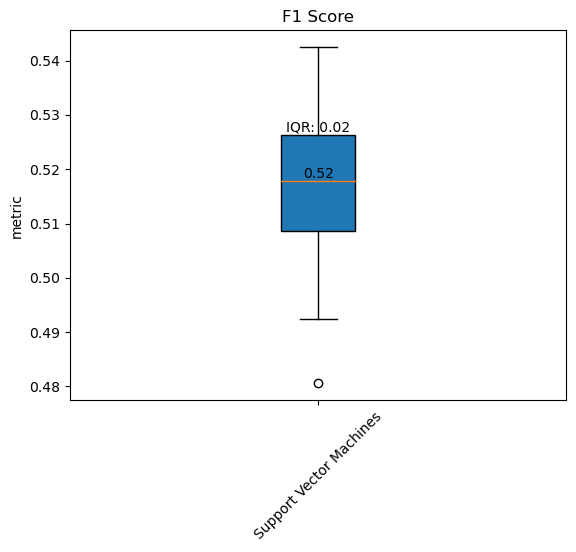

In [35]:
metric = 'F1 Score'
nCV.plotMetric(metric, 'Support Vector Machines')

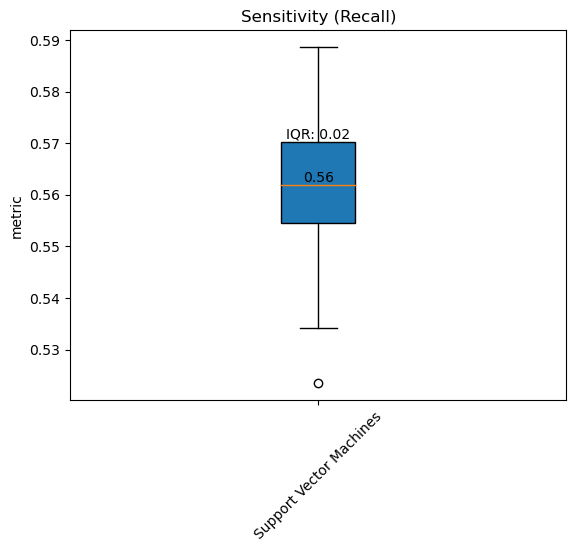

In [36]:
metric = 'Sensitivity (Recall)'
nCV.plotMetric(metric, 'Support Vector Machines')

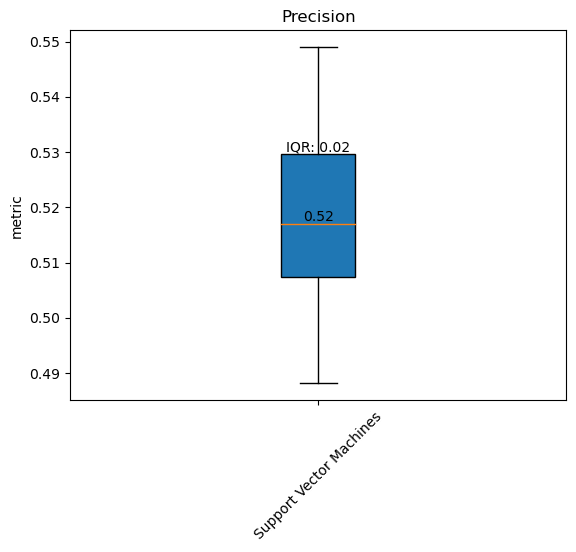

In [37]:
metric = 'Precision'
nCV.plotMetric(metric, 'Support Vector Machines')